In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime

In [53]:
nx = 256
L = 1
u_mag = 2
k = np.pi

config = {
    'domain': {
        'minExtent': -L,
        'maxExtent': L,
        'dim': 2,
        'periodic': True
    },
    'particle': {
        'nx': nx
    },
    'compute':{
        'device': 'cuda'
    },
    'fluid':{
        'cs' : u_mag * 10
    },
    'shifting':{
        'scheme': 'deltaSPH',
        'threshold': 0.05,
        'maxIterations': 1,
        'freeSurface': False
    },
}
config = parseDefaultParameters(config)
config = parseModuleParameters(config)

# display(config)

In [54]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict


ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.25,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sphere_a
# plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

noiseConfig = {
    'n': nx,
    'baseFrequency': 1,
    'dim': 2,
    'octaves': 3,
    'persistence': 0.5,
    'lacunarity': 2.0,
    'seed': 23467586,
    'tileable': True,
    'kind': 'simplex'
}


particleState, mask = sampleNoisyParticles(noiseConfig, config, sdfs = [])

In [63]:
from diffSPH.v2.modules.divergence import computeDivergence
perennialState = copy.deepcopy(particleState)

priorState = None
config['diffusion']['velocityScheme'] = 'deltaSPH_inviscid'
config['diffusion']['nu'] = 0.01

# omega = 4

# k = np.pi

u_max = torch.linalg.norm(perennialState['fluidVelocities'], dim = 1).max()

perennialState['fluidVelocities'] = perennialState['fluidVelocities'] / u_max * u_mag
initialVelocities = perennialState['fluidVelocities'].clone()

# perennialState['fluidVelocities'][:,0] =  u_mag * torch.cos(k * perennialState['fluidPositions'][:,0]) * torch.sin(k * perennialState['fluidPositions'][:,1])
# perennialState['fluidVelocities'][:,1] = -u_mag * torch.sin(k * perennialState['fluidPositions'][:,0]) * torch.cos(k * perennialState['fluidPositions'][:,1])

# # perennialState['fluidVelocities'][:,0] =  omega * perennialState['fluidPositions'][:,1]
# # perennialState['fluidVelocities'][:,1] = -omega * perennialState['fluidPositions'][:,0]
# perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
# perennialState['fluidDivergence'] = computeDivergence(perennialState, config)
# printState(perennialState)

In [64]:
k = 4 * np.pi

# perennialState['fluidVelocities'][:,0] =  u_mag * torch.cos(k * perennialState['fluidPositions'][:,0]) * torch.sin(k * perennialState['fluidPositions'][:,1])
# perennialState['fluidVelocities'][:,1] = -u_mag * torch.sin(k * perennialState['fluidPositions'][:,0]) * torch.cos(k * perennialState['fluidPositions'][:,1])
initialVelocities = perennialState['fluidVelocities'].clone()

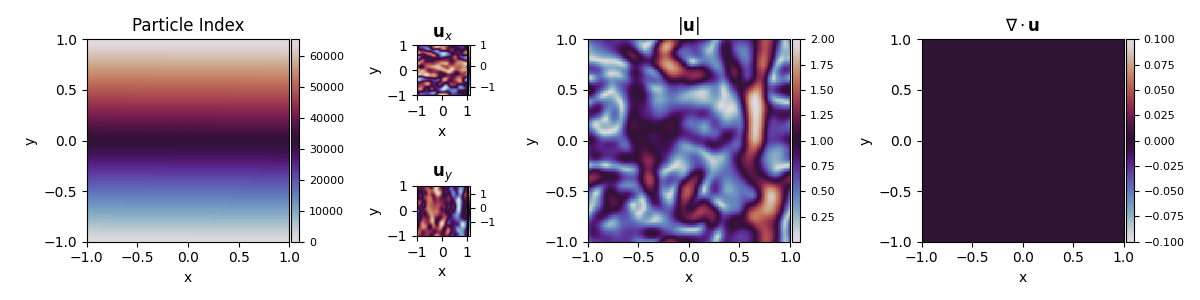

In [65]:
s = 4
fig, axis = plt.subplot_mosaic(\
'''AADBBCC
AAEBBCC''', figsize=(12,3), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)

plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, perennialState['fluidIndex'] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
plotVelUIndex = visualizeParticles(fig, axis['D'], config, visualizationState, perennialState['fluidVelocities'][:,0] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotVelVIndex = visualizeParticles(fig, axis['E'], config, visualizationState, perennialState['fluidVelocities'][:,1] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotVelMagIndex = visualizeParticles(fig, axis['B'], config, visualizationState, torch.norm(perennialState['fluidVelocities'], dim = 1) , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotDivergenceIndex = visualizeParticles(fig, axis['C'], config, visualizationState, perennialState['fluidDivergence'] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')

axis['A'].set_title('Particle Index')
axis['B'].set_title(r'$|\mathbf{u}|$')
axis['D'].set_title(r'$\mathbf{u}_x$')
axis['E'].set_title(r'$\mathbf{u}_y$')
axis['C'].set_title(r'$\nabla \cdot \mathbf{u}$')

fig.tight_layout()

tensor([0.5167, 0.5606, 0.5972,  ..., 0.3275, 0.3881, 0.4440], device='cuda:0')


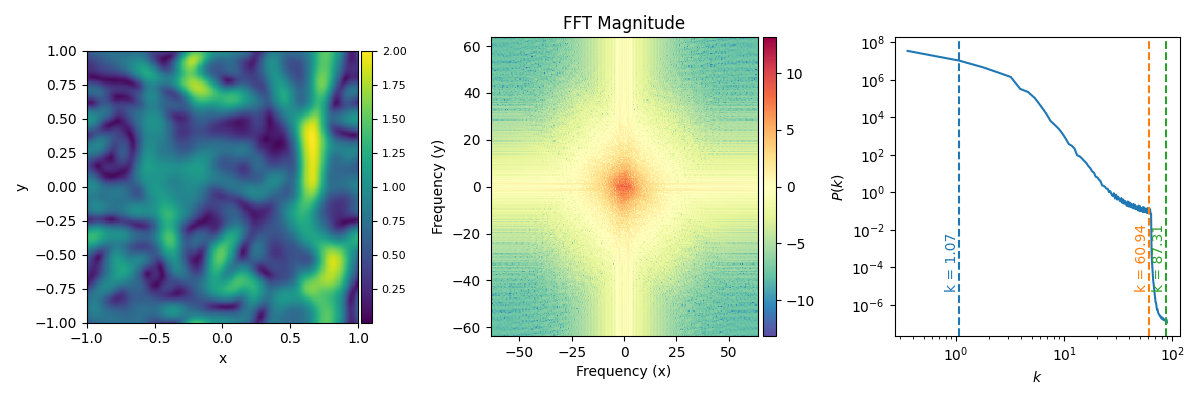

In [66]:
from diffSPH.v2.plotting import computePSD, plotFFT, plotPSD

data = torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)
# data = perennialState['fluidIndex'].to(torch.float32)

# data = torch.sin(2 * np.pi * perennialState['fluidPositions'][:,0]) + torch.sin(2 * np.pi * perennialState['fluidPositions'][:,1])


visualizationState, physical_freqs_xx, physical_freqs_yy, fft_mag, kvals, Abins, peaks = computePSD(perennialState, data, config, nGrid = 255)

print(data)

fig, axis = plt.subplot_mosaic('''ABC''', figsize=(12,4), sharex = False, sharey = False)

plotVelMagIndex = visualizeParticles(fig, axis['A'], config, visualizationState, data, cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotFFT(fig, axis['B'], physical_freqs_xx, physical_freqs_yy, fft_mag)
plotPSD(fig, axis['C'], kvals, Abins, peaks = peaks)


fig.tight_layout()

In [67]:
from diffSPH.v2.modules.viscosity import computeViscosityParameter
import matplotlib
from diffSPH.v2.plotting import setPlotBaseAttributes, mapToGrid

nu_sph = computeViscosityParameter(perennialState, config)
Re = u_mag * 2 / nu_sph
print(rf'Re = {Re}, $\nu_{{sph}} = {nu_sph}$')

Re = 4317.56201171875, $\nu_{sph} = 0.000926448788959533$


E_k0 = 1437, E_k = 1437, rel. diff = 0.00%


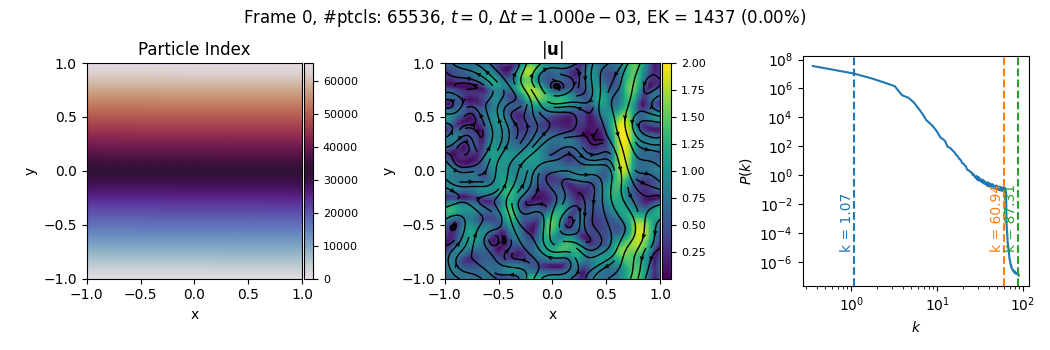

In [68]:
s = 2

fig, axis = plt.subplot_mosaic('''ACB''', figsize=(10.5,3.5), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)
# val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
# plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
# axis['A'].set_title(r'$P/\rho\omega^2L^2$')

val = perennialState['fluidIndex']
plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis['A'].set_title(r'Particle Index')

# plotDensityIndex = visualizeParticles(fig, axis['B'], config, visualizationState, perennialState['fluidDensities'] , cbar = True, cmap = 'Spectral_r', scaling = 'sym', midPoint = config['fluid']['rho0'], gridVisualization= False, s = s, mapping = '.x')
# axis['B'].set_title(r'$\rho$')

plotVelocityMagIndex = visualizeParticles(fig, axis['C'], config, visualizationState, torch.norm(perennialState['fluidVelocities'], dim = 1) , cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
axis['C'].set_title(r'$|\mathbf{u}|$')

grid_ux = mapToGrid(visualizationState, perennialState['fluidVelocities'][:,0])
grid_uy = mapToGrid(visualizationState, perennialState['fluidVelocities'][:,1])
X = visualizationState['X']
Y = visualizationState['Y']

stream = axis['C'].streamplot(X.detach().cpu().numpy(), Y.detach().cpu().numpy(), grid_ux.reshape(visualizationState['nGrid'], visualizationState['nGrid']).detach().cpu().numpy(), grid_uy.reshape(visualizationState['nGrid'], visualizationState['nGrid']).detach().cpu().numpy(), color='k', linewidth=1, density=1, arrowstyle='->', arrowsize=0.5)

data = torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)
visualizationState, physical_freqs_xx, physical_freqs_yy, fft_mag, kvals, Abins, peaks = computePSD(perennialState, data, config, nGrid = 255)

# plotVelMagIndex = visualizeParticles(fig, axis['A'], config, visualizationState, data, cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
# plotFFT(fig, axis['B'], physical_freqs_xx, physical_freqs_yy, fft_mag)
plotPSD(fig, axis['B'], kvals, Abins, peaks = peaks)



E_k0 =  (0.5 * particleState['fluidAreas'] * particleState['fluidDensities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()

E_k = (0.5 * torch.sum(perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidVelocities'], dim = 1)**2)).sum().detach().cpu().numpy()

print(f'E_k0 = {E_k0:.4g}, E_k = {E_k:.4g}, rel. diff = {(E_k - E_k0)/E_k0:.2%}')

config['timestep']['dt'] = 0.003

fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState["numParticles"]}, $t = {perennialState["time"] :.3g}$, $\Delta t = {perennialState["dt"]:.3e}$, EK = {E_k:.4g} ({(E_k - E_k0)/E_k0:.2%})''')

# axis['A'].set_xlim(perennialState['fluidPositions'][:,0].min().cpu().item()*1.1, perennialState['fluidPositions'][:,0].max().cpu().item()*1.1)
# axis['A'].set_ylim(perennialState['fluidPositions'][:,1].min().cpu().item()*1.1, perennialState['fluidPositions'][:,1].max().cpu().item()*1.1)

fig.tight_layout()


In [70]:
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
outFolder = './output/' + timestamp + '/'
os.makedirs(outFolder, exist_ok = True)
savedStates = []
EKs = []
times = []
dts = []
    
pbar = tqdm(total=4)

# for i in tqdm(range(1000)):
while(True):
    perennialState, *priorState = integrate(simulationStep, perennialState, config, previousStep= priorState)
    # Particle shifting
    dx, _ = solveShifting(perennialState, config)
    perennialState['fluidPositions'] += dx
    times.append(perennialState['time'] if not isinstance(perennialState['time'], torch.Tensor) else perennialState['time'].cpu().item())
    dts.append(config['timestep']['dt'] if not isinstance(config['timestep']['dt'], torch.Tensor) else config['timestep']['dt'].cpu().item())
    # Frame done, update state for next timestep
    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    perennialState['dt'] = config['timestep']['dt']
    
    config['timestep']['dt'] = computeTimestep(perennialState, config)
    time = perennialState['time']
    dt = config['timestep']['dt']

    pbar.n = perennialState['time'] if not isinstance(perennialState['time'], torch.Tensor) else perennialState['time'].cpu().item()
    pbar.refresh()
    if perennialState['time'] > 4:
        break

    # if perennialState['time'] * omega > 10:
        # break
    if perennialState['timestep'] % 250 == 0:
        savedStates.append(copy.deepcopy(perennialState))
        # print(perennialState['timestep'], perennialState['time'], config['timestep']['dt'])
    E_k = (0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2).sum().detach().cpu().numpy()
    EKs.append(E_k)
    # print(perennialState['timestep'], perennialState['time'], config['timestep']['dt'], E_k.sum().detach().cpu().numpy(), nu_total, Re_sim)
    
    if perennialState["timestep"] % 8 == 1:       
        fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState["numParticles"]}, $t = {perennialState["time"] :.3g}$, $\Delta t = {perennialState["dt"]:.3e}$, EK = {E_k:.4g} ({(E_k - E_k0)/E_k0:.2%})''')

        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(plotStateIndex, visualizationState, perennialState['fluidIndex'])
        # updatePlot(plotDensityIndex, visualizationState, perennialState['fluidDensities'])
        updatePlot(plotVelocityMagIndex, visualizationState, torch.norm(perennialState['fluidVelocities'], dim = 1))

        data = torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)
        visualizationState, physical_freqs_xx, physical_freqs_yy, fft_mag, kvals, Abins, peaks = computePSD(perennialState, data, config, nGrid = 255)

        # plotVelMagIndex = visualizeParticles(fig, axis['A'], config, visualizationState, data, cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
        # plotFFT(fig, axis['B'], physical_freqs_xx, physical_freqs_yy, fft_mag)
        axis['B'].cla()
        plotPSD(fig, axis['B'], kvals, Abins, peaks = peaks)

        grid_ux = mapToGrid(visualizationState, perennialState['fluidVelocities'][:,0])
        grid_uy = mapToGrid(visualizationState, perennialState['fluidVelocities'][:,1])
        X = visualizationState['X']
        Y = visualizationState['Y']

        stream.lines.remove() # https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
        for art in axis['C'].get_children():
            if not isinstance(art, matplotlib.patches.FancyArrowPatch):
                continue
            art.remove() 
            

        stream = axis['C'].streamplot(X.detach().cpu().numpy(), Y.detach().cpu().numpy(), grid_ux.reshape(visualizationState['nGrid'], visualizationState['nGrid']).detach().cpu().numpy(), grid_uy.reshape(visualizationState['nGrid'], visualizationState['nGrid']).detach().cpu().numpy(), color='k', linewidth=1, density=1, arrowstyle='->', arrowsize=0.5)

        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(outFolder + 'frame_{:04d}.png'.format(perennialState["timestep"]), dpi = 300)
# savedStates.append(copy.deepcopy(perennialState))

  0%|          | 0/4 [00:00<?, ?it/s]

In [72]:
import subprocess
import shlex
output = 'timestamp'
scale = 1280

command = '/usr/bin/ffmpeg -loglevel warning -hide_banner -y -framerate 60 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r 30 ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale={scale}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps=30,scale={scale}:-1:flags=lanczos[x];[x][1:v]paletteuse" {timestamp if output == "timestamp" else output}.gif'

print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
subprocess.run(shlex.split(command))
print('Creating gif palette')
subprocess.run(shlex.split(commandB))
print('Creating gif')
subprocess.run(shlex.split(commandC))
print('Done')

Creating video from  frames (frame count: 465)
Creating gif palette
Creating gif
Done


![](2024_03_08-14_01_15.gif)
![](2024_03_08-14_20_02.gif)

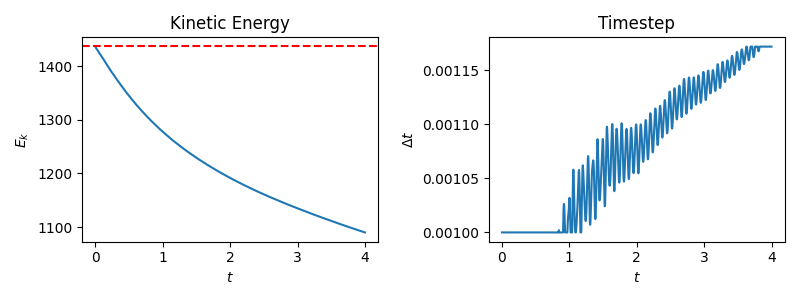

In [74]:
fig, axis = plt.subplot_mosaic(\
'''AB''', figsize=(8,3), sharex = False, sharey = False)

plot = axis['A'].plot(times[:-1], EKs)
axis['A'].axhline(E_k0, color = 'r', linestyle = '--')
axis['A'].set_title('Kinetic Energy')
axis['A'].set_xlabel(r'$t$')
axis['A'].set_ylabel(r'$E_k$')

axis['B'].plot(times, dts)
axis['B'].set_title('Timestep')
axis['B'].set_xlabel(r'$t$')
axis['B'].set_ylabel(r'$\Delta t$')


fig.tight_layout()




In [156]:
nu_sph = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support']  / (2 * (config['domain']['dim'] + 2)) * 5/4# / config['kernel']['kernelScale']
nu_sph = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu_sph

# nu = torch.log(E_k / E_k0) / (-a * b * k**2)
k = 4 * np.pi
nu_total = np.log(EKs[-1] / E_k0) / (-4 * perennialState['time'] * k**2 )

print(nu_total)
print(nu_sph)

tensor(0.0036, device='cuda:0')
tensor(0.0037, device='cuda:0')


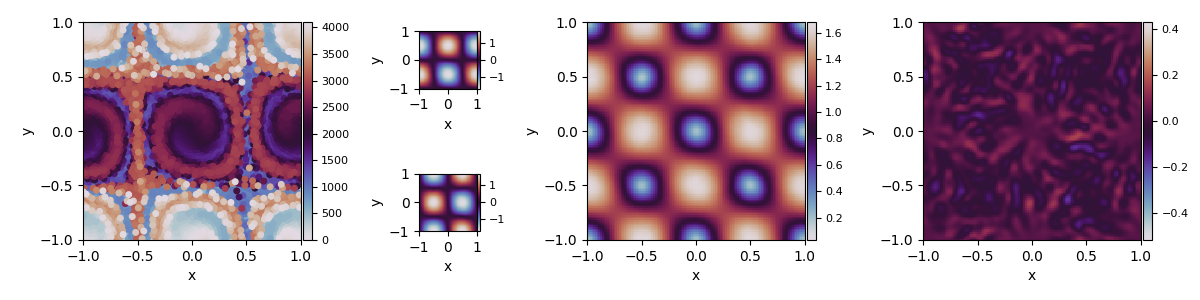

In [11]:
s = 16
fig, axis = plt.subplot_mosaic(\
'''AADBBCC
AAEBBCC''', figsize=(12,3), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)

plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, perennialState['fluidIndex'] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
plotVelUIndex = visualizeParticles(fig, axis['D'], config, visualizationState, perennialState['fluidVelocities'][:,0] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotVelVIndex = visualizeParticles(fig, axis['E'], config, visualizationState, perennialState['fluidVelocities'][:,1] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotVelMagIndex = visualizeParticles(fig, axis['B'], config, visualizationState, torch.norm(perennialState['fluidVelocities'], dim = 1) , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
plotDivergenceIndex = visualizeParticles(fig, axis['C'], config, visualizationState, perennialState['fluidDivergence'] , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')

fig.tight_layout()

1.1720738 1.4074038


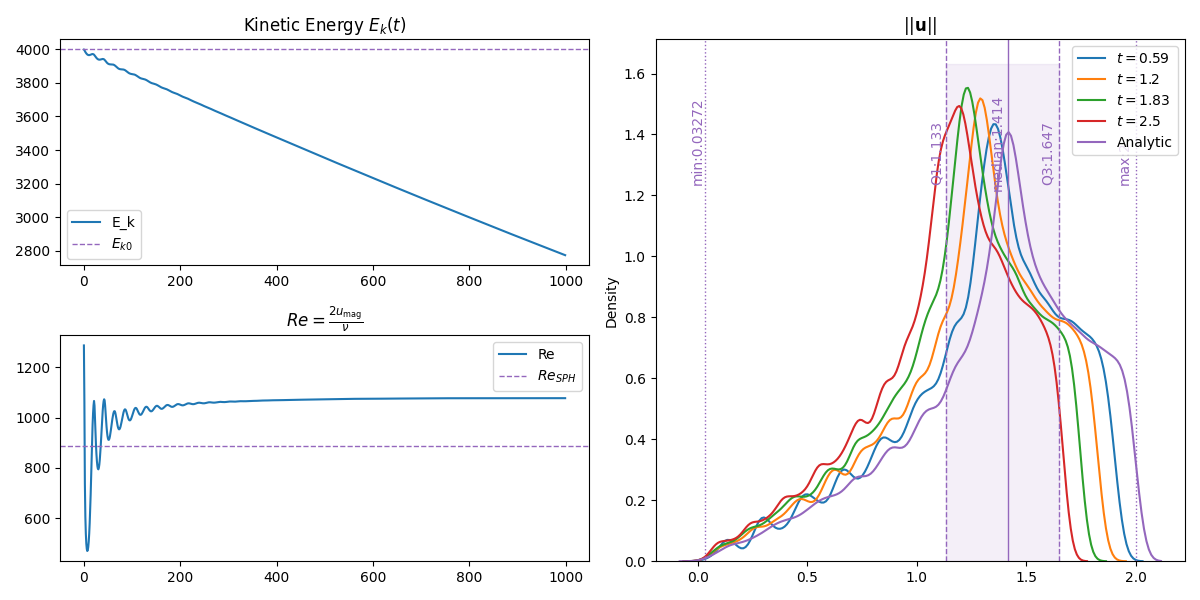

In [12]:
import seaborn as sns

def compute_nu(u, u_ref, t, k):
    if not isinstance(u_ref, torch.Tensor) or u_ref.ndim == 1:
        return torch.log(u) /(-np.log(u_ref) * k**2 * t)
    else:
        return torch.log(torch.linalg.norm(u, dim = -1)) /(-torch.log(torch.linalg.norm(u_ref, dim = -1)) * k**2 * t)   


minDomain = config['domain']['minExtent']
maxDomain = config['domain']['maxExtent']
# periodicity = config['domain']['periodic']
x = perennialState['fluidPositions']
periodicity = torch.tensor([config['domain']['periodic']] * x.shape[1], dtype = torch.bool).to(x.device)
positions = torch.stack([x[:,i] if not periodic_i else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)



nu_max = compute_nu(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1).max(), 2, perennialState['time'], k)

# nu_max = torch.log(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1).max()) /(-2 * np.pi**2 * perennialState['time'])
# nu = (torch.log(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)) /(-torch.linalg.norm(analyticVelocities, dim = -1) * np.pi**2 * perennialState['time'])).detach().cpu().numpy()
nu = compute_nu(perennialState['fluidVelocities'], analyticVelocities, perennialState['time'], k)

# nu_sph = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] / (2 * (config['domain']['dim'] +2))
# nu_sph = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu_sph


fig, ax = plt.subplot_mosaic(\
'''AB
CB''', figsize=(12,6), sharex = False, sharey = False)


median_velocity = torch.median(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)).detach().cpu().numpy()
median_analytic = torch.median(torch.linalg.norm(analyticVelocities, dim = -1)).detach().cpu().numpy()
print(median_velocity, median_analytic)

# median_velocity = torch.median(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)).detach().cpu().numpy()
viscosity = np.log(median_velocity) / (-median_analytic * np.pi**2 * perennialState['time'])

nu_data = (np.log(torch.max(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)).detach().cpu().numpy()) / (-2 * np.pi**2 * perennialState['time'])).detach().cpu().numpy()
# print(viscosity)
# print(np.median(nu))

# ax[].set_title(r'$\nu_i = \frac{\log{||\mathbf{u}_i||}}{- ||\mathbf{u}_{\text{analytic}}|| \pi^2 t}$')
ax['B'].set_title(r'$||\mathbf{u}||$')

def plotStatistics(ax, data, color, offset = 0):
    ax.axvline(np.median(data), color = color, lw = 1, ls = '-')
    ax.text(np.median(data)*0.99, ax.get_ylim()[1]/4 + offset, f'median:{np.median(data):.4g}', color = color, ha = 'right', rotation = 90)

    q1, q3 = np.percentile(data, [25,75])
    ax.axvline(q1, color = color, lw = 1, ls = '--')
    ax.axvline(q3, color = color, lw = 1, ls = '--')
    ax.fill_betweenx(ax.get_ylim(), q1, q3, color = color, alpha = 0.1)
    ax.text(q1*0.99, ax.get_ylim()[1]/4 + offset, f'Q1:{q1:.4g}', color = color, ha = 'right', rotation = 90)
    ax.text(q3*0.99, ax.get_ylim()[1]/4 + offset, f'Q3:{q3:.4g}', color = color, ha = 'right', rotation = 90)
    
    ax.axvline(np.max(data), color = color, lw = 1, ls = ':')
    ax.axvline(np.min(data), color = color, lw = 1, ls = ':')
    ax.text(np.max(data)*0.99, ax.get_ylim()[1]*1/4 + offset, f'max:{np.max(data):.4g}', color = color, ha = 'right', rotation = 90)
    ax.text(np.min(data)*0.99, ax.get_ylim()[1]*1/4 + offset, f'min:{np.min(data):.4g}', color = color, ha = 'right', rotation = 90)

for state in savedStates:
    x = state['fluidPositions']
    positions = torch.stack([x[:,i] if not periodic_i else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

    analyticVelocities[:,0] =  u_mag * torch.cos(k * positions[:,0]) * torch.sin(k * positions[:,1])
    analyticVelocities[:,1] = -u_mag * torch.sin(k * positions[:,0]) * torch.cos(k * positions[:,1])

    nu = compute_nu(state['fluidVelocities'], analyticVelocities, state['time'], k).detach().cpu().numpy()
    # nu = (torch.log(torch.linalg.norm(state['fluidVelocities'], dim = -1)) /(-torch.log(torch.linalg.norm(analyticVelocities, dim = -1)) * np.pi**2 * state['time'])).detach().cpu().numpy()

    # hist = sns.kdeplot(nu, ax = ax[0,0], log_scale= False, bw_adjust = 0.5, label = rf'$t = {{:.3g}}$'.format(state['time']))

    # print(torch.linalg.norm(state['fluidVelocities'], dim = -1))
    # print(torch.linalg.norm(analyticVelocities, dim = -1))
    # print(nu)
    sns.kdeplot(torch.linalg.norm(state['fluidVelocities'], dim = -1).detach().cpu().numpy(), ax = ax['B'], label = rf'$t = {{:.3g}}$'.format(state['time']), bw_adjust = 0.5)



sns.kdeplot(torch.linalg.norm(analyticVelocities, dim = -1).detach().cpu().numpy(), ax = ax['B'], label = 'Analytic', bw_adjust = 0.5)


ax['B'].legend()
# plotStatistics(ax[0,0], nu, sns.color_palette()[len(savedStates) - 1], offset = ax[0,0].get_ylim()[1]/2)
# plotStatistics(ax['B'], torch.linalg.norm(perennialState['fluidVelocities'], dim = -1).detach().cpu().numpy(), sns.color_palette()[len(savedStates) - 1])
plotStatistics(ax['B'], torch.linalg.norm(analyticVelocities, dim = -1).detach().cpu().numpy(), sns.color_palette()[len(savedStates)], offset = ax['B'].get_ylim()[1]/2)

ax['A'].set_title(rf'Kinetic Energy $E_k(t)$')
ax['A'].plot(EKs, label = 'E_k')
ax['A'].axhline(E_k0.sum().detach().cpu().numpy(), color = sns.color_palette()[len(savedStates)], lw = 1, ls = '--', label = r'$E_{k0}$')
ax['A'].legend()

ax['C'].set_title(r'$Re = \frac{2 u_\text{mag}}{\nu}$')
ax['C'].plot(Res, label = 'Re')
ax['C'].axhline(Re_sph.cpu().detach().numpy(), color = sns.color_palette()[len(savedStates)], lw = 1, ls = '--', label = r'$Re_{SPH}$')
ax['C'].legend()
# ax[0,0].axvline(nu_sph.detach().cpu().numpy(), color = sns.color_palette()[len(savedStates) + 1], lw = 1, ls = '-')
# ax[0,0].text(nu_sph.detach().cpu().numpy()*0.99, ax[0,0].get_ylim()[1]/4, f'$\\nu_{{SPH}} = {nu_sph:.4g}$', color = sns.color_palette()[len(savedStates) + 1], ha = 'right', rotation = 90)

# ax[0,0].axvline(nu_data, color = sns.color_palette()[len(savedStates) + 1], lw = 1, ls = '-')
# ax[0,0].text(nu_data*0.99, ax[0,0].get_ylim()[1]*3/4, f'$\\nu_{{Data}} = {nu_data:.4g}$', color = sns.color_palette()[len(savedStates) + 1], ha = 'left', rotation = 90)
fig.tight_layout()

In [51]:
analyticVelocities = torch.clone(perennialState['fluidVelocities'])
analyticVelocities[:,0] =  u_mag * torch.cos(k * positions[:,0]) * torch.sin(k * positions[:,1])
analyticVelocities[:,1] = -u_mag * torch.sin(k * positions[:,0]) * torch.cos(k * positions[:,1])
E_k0 =  0.5 * particleState['fluidAreas'] * particleState['fluidDensities'] * torch.linalg.norm(analyticVelocities, dim = -1)**2
E_k0 =  0.5 * particleState['fluidAreas'] * particleState['fluidDensities'] * torch.linalg.norm(analyticVelocities, dim = -1)**2

a = (config['domain']['maxExtent'] - config['domain']['minExtent'])[0]
b = (config['domain']['maxExtent'] - config['domain']['minExtent'])[1]

E_k = 0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2


print(E_k0.sum())
print(E_k.sum())

# decay_rate = exp(-a * b * k**2 * nu_sph)


nu_sph = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support']  / (2 * (config['domain']['dim'] + 2)) * 5/4# / config['kernel']['kernelScale']
nu_sph = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu_sph

nu = torch.log(E_k / E_k0) / (-a * b * k**2)
nu_total = torch.log(E_k.sum() / E_k0.sum()) / (-4 * perennialState['time'] * k**2 )
print(nu_total)
print(nu_sph)
print(f'Re_sph = {u_mag * 2 / nu_sph}')
print(f'Re_sim = {u_mag * 2 / nu_total}')

tensor(4000.3447, device='cuda:0')
tensor(2773.7471, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')
Re_sph = 1079.3905029296875
Re_sim = 1077.37255859375


In [47]:
particleState['fluidSupports']

tensor([0.1186, 0.1186, 0.1186,  ..., 0.1186, 0.1186, 0.1186], device='cuda:0')

In [48]:
config['particle']['dx'] * 2 * config['kernel']['kernelScale']

tensor(0.1186, device='cuda:0')

In [50]:
nu_sph / nu_total * 5/4

tensor(0.9981, device='cuda:0')

In [22]:
(u_mag * 2 / nu_sph) / (u_mag * 2 / nu_total)

tensor(1.5242, device='cuda:0')

In [233]:
1/1.2457

0.8027614995584812

0.43671292 0.70635235
tensor([0.0644, 0.1458, 0.2365,  ..., 0.2338, 0.1412, 0.0608], device='cuda:0')
tensor([0.0709, 0.1614, 0.2627,  ..., 0.2610, 0.1574, 0.0680], device='cuda:0')
[-0.08677246 -0.08841715 -0.0903156  ... -0.09060817 -0.08864953
 -0.08721221]
tensor([0.0573, 0.1309, 0.2093,  ..., 0.2072, 0.1212, 0.0485], device='cuda:0')
tensor([0.0733, 0.1624, 0.2600,  ..., 0.2590, 0.1505, 0.0614], device='cuda:0')
[-0.04368285 -0.04467365 -0.04637772 ... -0.04654321 -0.0444985
 -0.04329548]
tensor([0.0444, 0.1101, 0.1811,  ..., 0.1924, 0.0886, 0.0373], device='cuda:0')
tensor([0.0650, 0.1550, 0.2568,  ..., 0.2754, 0.1299, 0.0504], device='cuda:0')
[-0.02868414 -0.02978155 -0.03162153 ... -0.03216617 -0.02988414
 -0.02769451]
tensor([0.0334, 0.0890, 0.1529,  ..., 0.1767, 0.0743, 0.0324], device='cuda:0')
tensor([0.0721, 0.1632, 0.2651,  ..., 0.2739, 0.1059, 0.0434], device='cuda:0')
[-0.02288091 -0.0236256  -0.02503404 ... -0.02368898 -0.02049179
 -0.01934458]


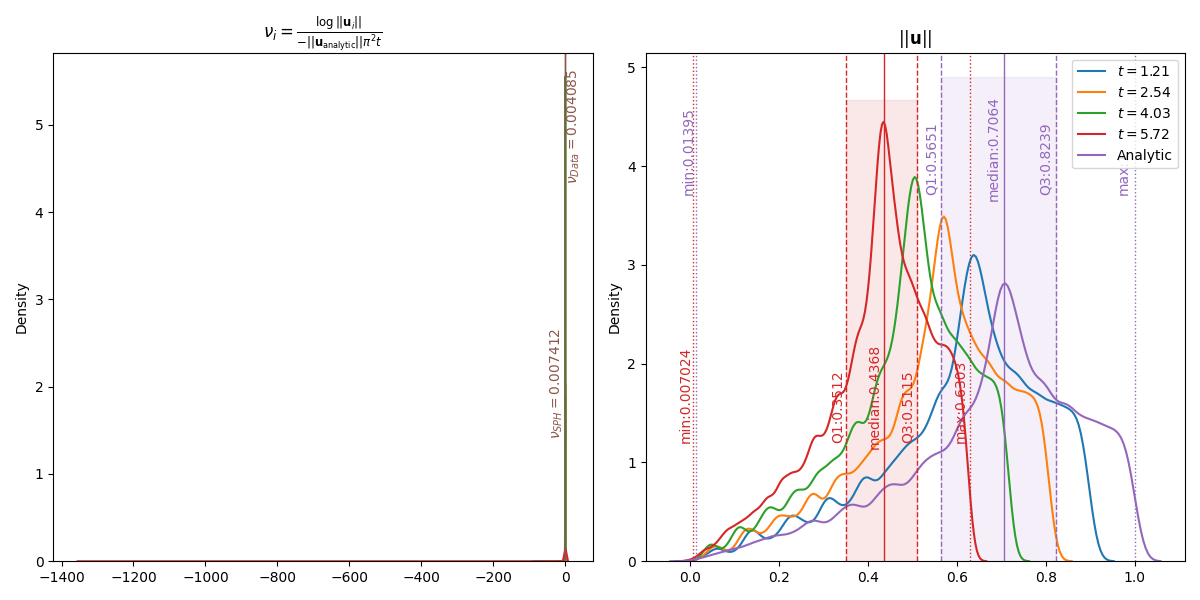

In [158]:
import seaborn as sns

def compute_nu(u, u_ref, t, k):
    if not isinstance(u_ref, torch.Tensor) or u_ref.ndim == 1:
        return torch.log(u) /(-np.log(u_ref) * k**2 * t)
    else:
        return torch.log(torch.linalg.norm(u, dim = -1)) /(-torch.log(torch.linalg.norm(u_ref, dim = -1)) * k**2 * t)   


minDomain = config['domain']['minExtent']
maxDomain = config['domain']['maxExtent']
# periodicity = config['domain']['periodic']
x = perennialState['fluidPositions']
periodicity = torch.tensor([config['domain']['periodic']] * x.shape[1], dtype = torch.bool).to(x.device)
positions = torch.stack([x[:,i] if not periodic_i else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

analyticVelocities = torch.clone(perennialState['fluidVelocities'])
analyticVelocities[:,0] =  u_mag * torch.cos(k * positions[:,0]) * torch.sin(k * positions[:,1])
analyticVelocities[:,1] = -u_mag * torch.sin(k * positions[:,0]) * torch.cos(k * positions[:,1])


nu_max = compute_nu(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1).max(), 2, perennialState['time'], k)

# nu_max = torch.log(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1).max()) /(-2 * np.pi**2 * perennialState['time'])
# nu = (torch.log(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)) /(-torch.linalg.norm(analyticVelocities, dim = -1) * np.pi**2 * perennialState['time'])).detach().cpu().numpy()
nu = compute_nu(perennialState['fluidVelocities'], analyticVelocities, perennialState['time'], k)

nu_sph = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] / (2 * (config['domain']['dim'] +2))
nu_sph = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu_sph


fig, ax = plt.subplots(1, 2, figsize = (12,6), squeeze = False)



median_velocity = torch.median(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)).detach().cpu().numpy()
median_analytic = torch.median(torch.linalg.norm(analyticVelocities, dim = -1)).detach().cpu().numpy()
print(median_velocity, median_analytic)

# median_velocity = torch.median(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)).detach().cpu().numpy()
viscosity = np.log(median_velocity) / (-median_analytic * np.pi**2 * perennialState['time'])

nu_data = (np.log(torch.max(torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)).detach().cpu().numpy()) / (-2 * np.pi**2 * perennialState['time'])).detach().cpu().numpy()
# print(viscosity)
# print(np.median(nu))

ax[0,0].set_title(r'$\nu_i = \frac{\log{||\mathbf{u}_i||}}{- ||\mathbf{u}_{\text{analytic}}|| \pi^2 t}$')
ax[0,1].set_title(r'$||\mathbf{u}||$')

def plotStatistics(ax, data, color, offset = 0):
    ax.axvline(np.median(data), color = color, lw = 1, ls = '-')
    ax.text(np.median(data)*0.99, ax.get_ylim()[1]/4 + offset, f'median:{np.median(data):.4g}', color = color, ha = 'right', rotation = 90)

    q1, q3 = np.percentile(data, [25,75])
    ax.axvline(q1, color = color, lw = 1, ls = '--')
    ax.axvline(q3, color = color, lw = 1, ls = '--')
    ax.fill_betweenx(ax.get_ylim(), q1, q3, color = color, alpha = 0.1)
    ax.text(q1*0.99, ax.get_ylim()[1]/4 + offset, f'Q1:{q1:.4g}', color = color, ha = 'right', rotation = 90)
    ax.text(q3*0.99, ax.get_ylim()[1]/4 + offset, f'Q3:{q3:.4g}', color = color, ha = 'right', rotation = 90)
    
    ax.axvline(np.max(data), color = color, lw = 1, ls = ':')
    ax.axvline(np.min(data), color = color, lw = 1, ls = ':')
    ax.text(np.max(data)*0.99, ax.get_ylim()[1]*1/4 + offset, f'max:{np.max(data):.4g}', color = color, ha = 'right', rotation = 90)
    ax.text(np.min(data)*0.99, ax.get_ylim()[1]*1/4 + offset, f'min:{np.min(data):.4g}', color = color, ha = 'right', rotation = 90)

for state in savedStates:
    x = state['fluidPositions']
    positions = torch.stack([x[:,i] if not periodic_i else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

    analyticVelocities[:,0] =  u_mag * torch.cos(k * positions[:,0]) * torch.sin(k * positions[:,1])
    analyticVelocities[:,1] = -u_mag * torch.sin(k * positions[:,0]) * torch.cos(k * positions[:,1])

    nu = compute_nu(state['fluidVelocities'], analyticVelocities, state['time'], k).detach().cpu().numpy()
    # nu = (torch.log(torch.linalg.norm(state['fluidVelocities'], dim = -1)) /(-torch.log(torch.linalg.norm(analyticVelocities, dim = -1)) * np.pi**2 * state['time'])).detach().cpu().numpy()

    hist = sns.kdeplot(nu, ax = ax[0,0], log_scale= False, bw_adjust = 0.5, label = rf'$t = {{:.3g}}$'.format(state['time']))

    print(torch.linalg.norm(state['fluidVelocities'], dim = -1))
    print(torch.linalg.norm(analyticVelocities, dim = -1))
    print(nu)
    sns.kdeplot(torch.linalg.norm(state['fluidVelocities'], dim = -1).detach().cpu().numpy(), ax = ax[0,1], label = rf'$t = {{:.3g}}$'.format(state['time']), bw_adjust = 0.5)



sns.kdeplot(torch.linalg.norm(analyticVelocities, dim = -1).detach().cpu().numpy(), ax = ax[0,1], label = 'Analytic', bw_adjust = 0.5)


ax[0,1].legend()
# plotStatistics(ax[0,0], nu, sns.color_palette()[len(savedStates) - 1], offset = ax[0,0].get_ylim()[1]/2)
plotStatistics(ax[0,1], torch.linalg.norm(perennialState['fluidVelocities'], dim = -1).detach().cpu().numpy(), sns.color_palette()[len(savedStates) - 1])
plotStatistics(ax[0,1], torch.linalg.norm(analyticVelocities, dim = -1).detach().cpu().numpy(), sns.color_palette()[len(savedStates)], offset = ax[0,1].get_ylim()[1]/2)

ax[0,0].axvline(nu_sph.detach().cpu().numpy(), color = sns.color_palette()[len(savedStates) + 1], lw = 1, ls = '-')
ax[0,0].text(nu_sph.detach().cpu().numpy()*0.99, ax[0,0].get_ylim()[1]/4, f'$\\nu_{{SPH}} = {nu_sph:.4g}$', color = sns.color_palette()[len(savedStates) + 1], ha = 'right', rotation = 90)

ax[0,0].axvline(nu_data, color = sns.color_palette()[len(savedStates) + 1], lw = 1, ls = '-')
ax[0,0].text(nu_data*0.99, ax[0,0].get_ylim()[1]*3/4, f'$\\nu_{{Data}} = {nu_data:.4g}$', color = sns.color_palette()[len(savedStates) + 1], ha = 'left', rotation = 90)
fig.tight_layout()

tensor(4000.4526, device='cuda:0')
tensor(3188.5337, device='cuda:0')
tensor(0.0024, device='cuda:0')
tensor(0.0030, device='cuda:0')
Re_sph = 1349.2381591796875
Re_sim = 1680.797119140625


In [160]:
analyticVelocities = torch.clone(perennialState['fluidVelocities'])
analyticVelocities[:,0] =  u_mag * torch.cos(k * positions[:,0]) * torch.sin(k * positions[:,1])
analyticVelocities[:,1] = -u_mag * torch.sin(k * positions[:,0]) * torch.cos(k * positions[:,1])
E_k0 =  0.5 * particleState['fluidAreas'] * particleState['fluidDensities'] * torch.linalg.norm(analyticVelocities, dim = -1)**2

a = (config['domain']['maxExtent'] - config['domain']['minExtent'])[0]
b = (config['domain']['maxExtent'] - config['domain']['minExtent'])[1]

E_k = 0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2


print(E_k0.sum())
print(E_k.sum())

# decay_rate = exp(-a * b * k**2 * nu_sph)

nu = torch.log(E_k / E_k0) / (-a * b * k**2)
nu_total = torch.log(E_k.sum() / E_k0.sum()) / (-4 * perennialState['time'] * k**2)
print(nu_total)
print(nu_sph)
print(f'Re_sph = {u_mag * 2 / nu_sph}')
print(f'Re_sim = {u_mag * 2 / nu_total}')

tensor(1000.1322, device='cuda:0')
tensor(388.7867, device='cuda:0')
tensor(0.0042, device='cuda:0')
tensor(0.0074, device='cuda:0')
Re_sph = 269.8476257324219
Re_sim = 478.34051513671875


In [18]:
Re = 2 * u_mag / nu_data
print(Re)
Re = 2 * u_mag / nu_sph
print(Re)

Re = 2 * u_mag / np.median(nu)
print(Re)

969.7737572893392
tensor(1349.2382, device='cuda:0')
276.356027000865


In [61]:
print(nu_max)

<Axes: title={'center': '$\\nu_i$'}, ylabel='Count'>

In [10]:
import subprocess
import shlex

command = '/usr/bin/ffmpeg -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r 30 ' + outFolder + 'output.mp4'

# command = '/usr/bin/ffmpeg -hide_banner -y -r 60 -i ' + outFolder + 'frame_%04d.png -c:v libx264 -vf "fps=60,format=yuv420p" ' + outFolder + 'output.mp4'
subprocess.run(shlex.split(command))

import shlex

commandA = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale=1280:-1:flags=lanczos,palettegen" {outFolder}palette.png'
commandB = f'ffmpeg -hide_banner -y -i {outFolder}output.mp4 -i {outFolder}palette.png -filter_complex "fps=30,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse" squarePatch.gif'

subprocess.run(shlex.split(commandA))
subprocess.run(shlex.split(commandB))

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

CompletedProcess(args=['ffmpeg', '-hide_banner', '-y', '-i', './output/2024_03_06-15_31_28/output.mp4', '-i', './output/2024_03_06-15_31_28/palette.png', '-filter_complex', 'fps=30,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse', 'squarePatch.gif'], returncode=0)

<img src = "./squarePatch.gif" width = 500/>